https://www.kaggle.com/code/fangya/ubiquant-investment-mini-eda-lgbm-linreg

https://www.kaggle.com/code/ilialar/ubiquant-eda-and-baseline

对冲基金利用量化交易策略买卖大量股票和其他证券。定量交易策略在很大程度上依赖于数学建模来捕捉和识别交易机会。
Ubiquant Investment提供了300多万条具有300个功能的交易记录。在本笔记本中，我们将介绍量化交易的基本概念，探索投资EDA，研究目标与某些特征之间的关系，并构建模型来预测目标价值。
我们希望个人投资者能够从分析中受益，我们不需要像金融机构那样做，但当我们理解量化交易的概念时，我们会对自己的钱感觉更好！
注：这是一个迷你展览。由于这个庞大数据集的运行时间，我们将只使用部分数据来执行任务！

项目大纲

EDA

整体柱状图

相关图

目标变化

功能选择

常规功能

Lightbgm

建模

线性回归

CNN


一般交易步骤
当我们知道正确的信息、坚实的数学模型并在正确的时间执行时，一个好的交易系统就很容易了。
例如，如果我们知道辉瑞疫苗有效，该模型将根据我们的现金流计算我们应该购买多少股票。挑战在于确定明确的消息，建立正确的模型，并在没有任何个人感受的情况下执行。
资讯
建模
执行
量化交易关键指标
构建各种数学模型来自动化交易决策，以消除情绪决策
将回溯测试数据应用于各种场景，以帮助识别盈利机会
高频交易（HFT）只有在其他市场参与者不知道策略且市场状况没有变化的情况下才有益。

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import math
import lightgbm
from sklearn.model_selection import StratifiedKFold 
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import os 
os.chdir(r'E:\python code\量化交易数据')

数据概述

In [2]:
sns.color_palette("mako_r",10)

[(0.68051833, 0.88963189, 0.75150483),
 (0.4285828, 0.82635051, 0.6780564),
 (0.26604085, 0.73564353, 0.67914062),
 (0.20968223, 0.63088252, 0.6701105),
 (0.20418396, 0.53013715, 0.64946117),
 (0.21112526, 0.42903064, 0.6266318),
 (0.23807973, 0.32226344, 0.58941872),
 (0.25007383, 0.22365053, 0.45519562),
 (0.20976258, 0.14925954, 0.29687795),
 (0.13701138, 0.08259683, 0.15060265)]

数据读取

In [9]:
train = pd.read_parquet('train.parquet') 
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [12]:
train.tail()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
3141405,1219_3768,1219,3768,0.033600,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,1219_3769,1219,3769,-0.223264,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,1219_3770,1219,3770,-0.559415,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,1219_3772,1219,3772,0.009599,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040
3141409,1219_3773,1219,3773,1.212112,-0.089557,0.190229,-0.548256,0.151205,0.079773,0.447962,...,-0.317095,0.811402,3.271590,0.875537,0.421628,-0.170709,1.363181,-0.563314,0.669586,0.456400


In [10]:
train.shape

(3141410, 304)

row_id- 该行的唯一标识符。

time_id- 数据收集时间的 ID 代码。时间 ID 是按顺序排列的，但时间 ID 之间的实际时间并不恒定，最终的私有测试集的时间可能比训练集的时间短。

investment_id- 投资的 ID 代码。并非所有投资都有所有时间 ID 的数据。

target- 目标。

[f_0:f_299]- 从市场数据生成的匿名特征

In [13]:
def histg(data, color , label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    data.plot.hist(bins=60, color=color)
    plt.title(label)
    plt.show()

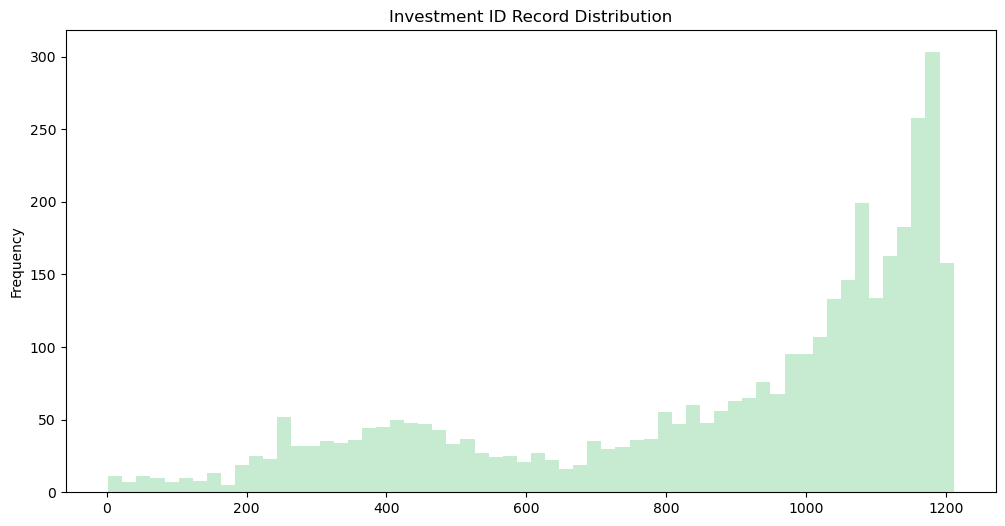

In [14]:
obs_by_asset = train.groupby(['investment_id'])['target'].count()
histg(obs_by_asset,"#c6ebd1", "Investment ID Record Distribution")


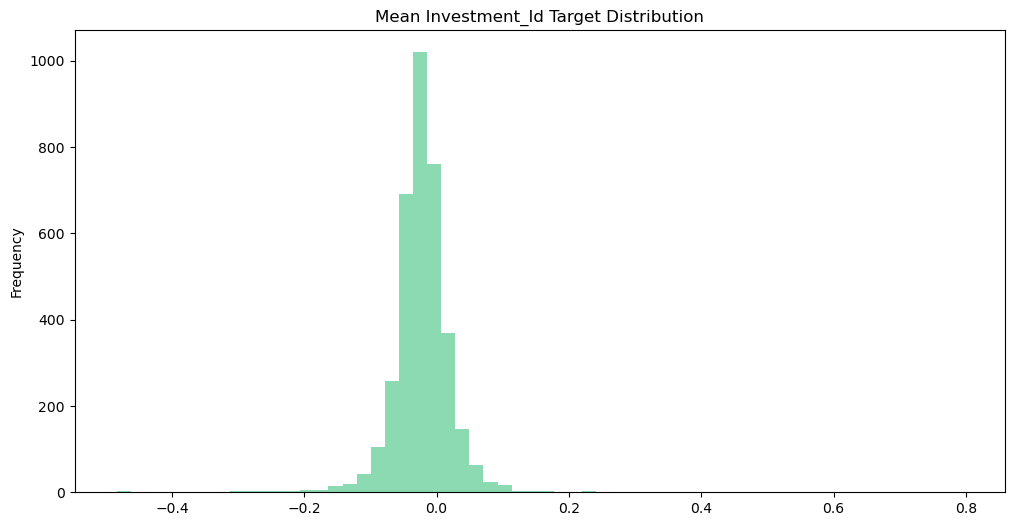

In [15]:
mean_target = train.groupby(['investment_id'])['target'].mean()
mean_mean_target = np.mean(mean_target)
histg(mean_target,"#8bdab2", "Mean Investment_Id Target Distribution")

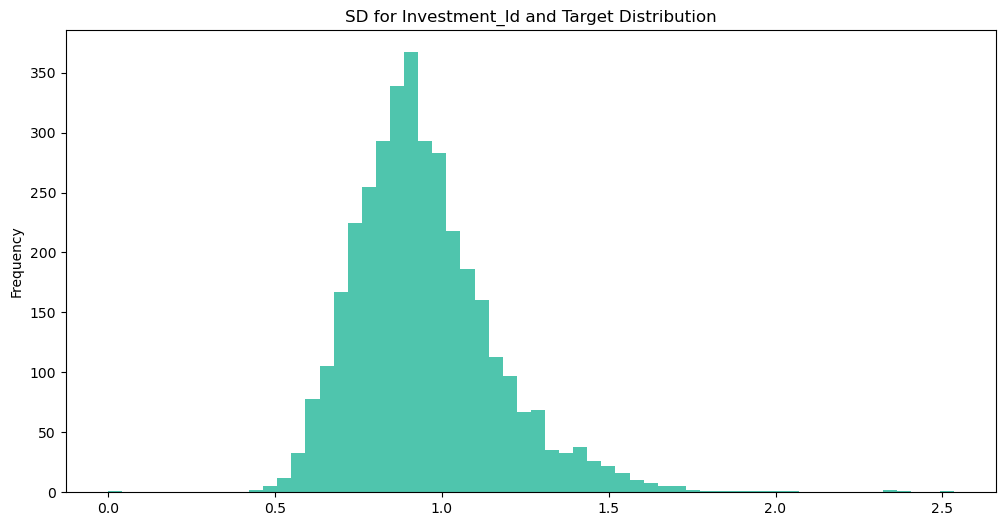

In [16]:
sts_target = train.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(sts_target)
histg(sts_target,"#4fc5ad", "SD for Investment_Id and Target Distribution")

Text(0.5, 1.05, 'Target Histogram of Different Investment ID')

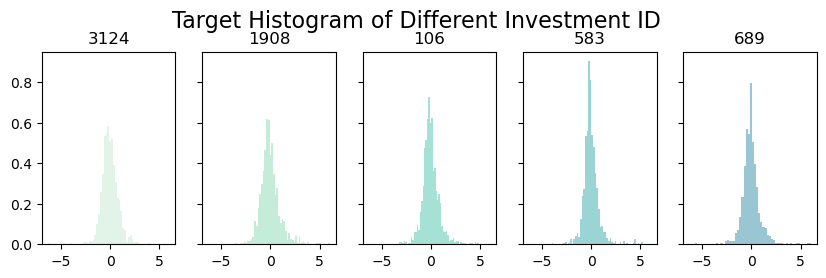

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
#colors = ['tab:green', 'tab:blue', 'tab:pink', 'tab:red', 'tab:purple']
colors = ["#c6ebd1","#8bdab2","#4fc5ad","#38aaac","#348fa7"]
for i, (ax, investment_id) in enumerate(zip(axes.flatten(), np.random.choice(train["investment_id"].unique(),5))):
    x = train.loc[train.investment_id==investment_id, "target"]
    ax.hist(x, alpha=0.5, bins=55, density=True, stacked=True, label=str(investment_id), color=colors[i])
    ax.set_title(investment_id)
plt.suptitle('Target Histogram of Different Investment ID', y=1.05, size=16)  

按时间记录唯一投资ID

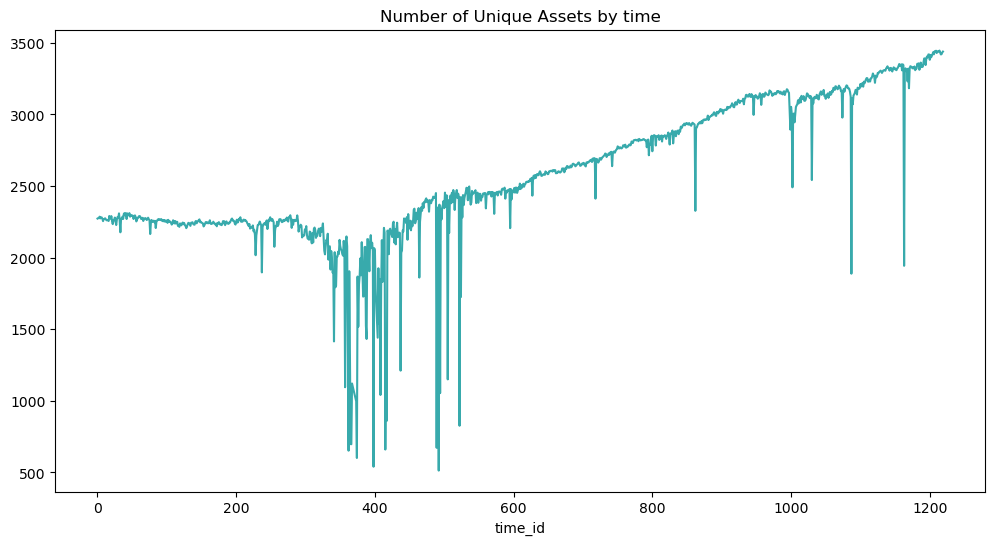

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
train.groupby('time_id')['investment_id'].nunique().plot(color="#38aaac")
plt.title("Number of Unique Assets by time")
plt.show()

每笔投资的记录数_ID

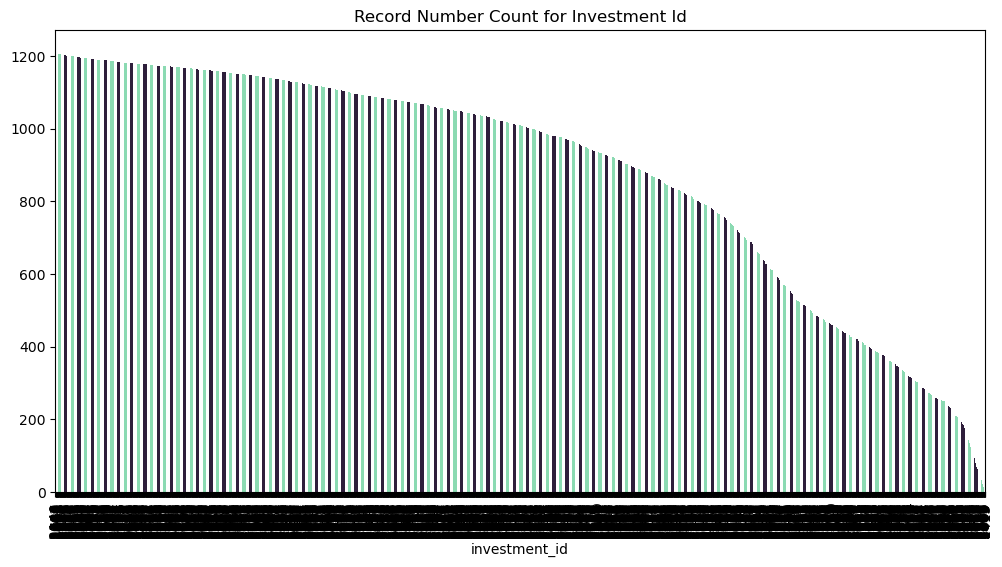

In [19]:
train['investment_id'].value_counts().plot(kind = 'bar',figsize = (12,6), color=("#8bdab2","#2e1e3b"))
plt.title("Record Number Count for Investment Id")
plt.show()

记录数字最多的前10个投资Id

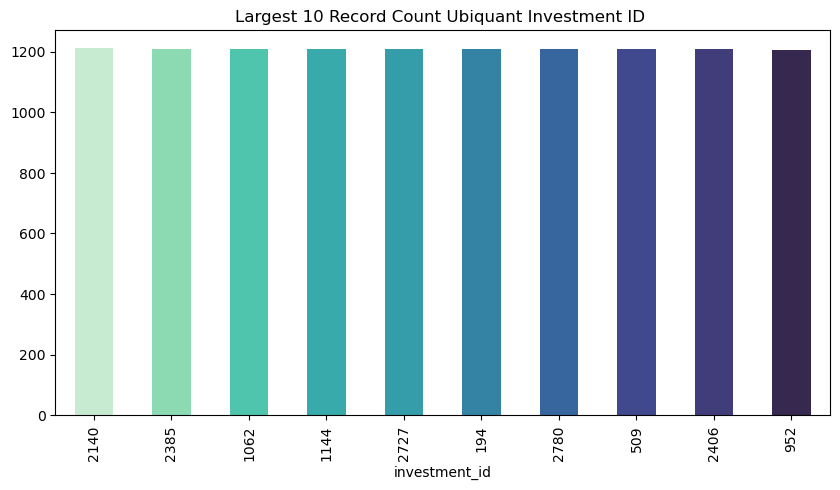

In [20]:
train['investment_id'].value_counts().nlargest(10).plot(kind = 'bar',figsize = (10,5), 
                        color=("#c6ebd1","#8bdab2","#4fc5ad", "#38aaac","#359caa","#3482a4",
                            "#37659e","#40498e","#413d7b","#37284f","#241628"))
plt.title("Largest 10 Record Count Ubiquant Investment ID ")
plt.show()

记录数最少的前10个投资Id

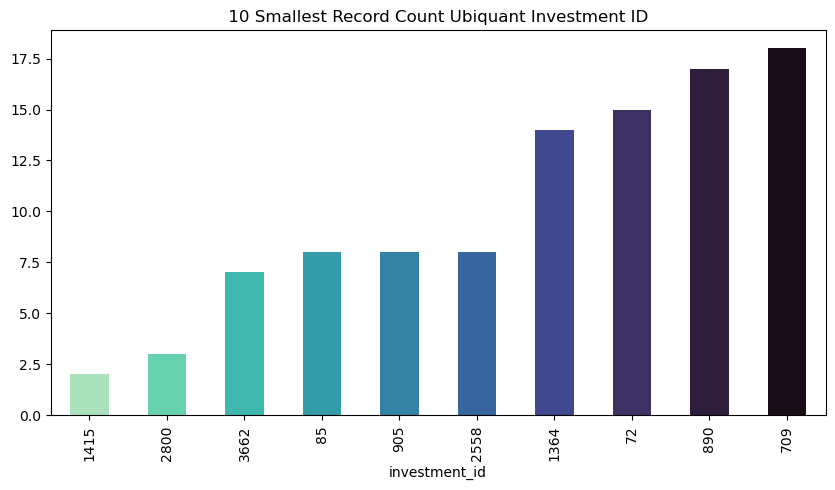

In [21]:
train['investment_id'].value_counts().nsmallest(10).plot(kind = 'bar',figsize = (10,5), 
                        color=("#abe2be","#68d1ad", "#40b7ad", "#359caa","#3482a4",
                             "#37659e","#40498e","#3d3164","#2e1e3b","#180d16"))
plt.title(" 10 Smallest Record Count Ubiquant Investment ID ")
plt.show()

目标值的投资ID和时间ID

我们可以看到，记录较多的投资ID具有较高的波动性，这意味着更容易产生套利和获利。例如，1415的目标值是一条直线，不会有任何投资机会。

In [22]:
array=[2140,2385,1062,1144,2727,194,2780,509,2406,952,1415,2800,3662,85,905]
s_id=train.loc[train['investment_id'].isin(array)]

In [23]:
def data_id(id1):
    df=s_id[s_id["investment_id"]==id1].set_index("time_id")
    return df

id1=data_id(2140)
id2=data_id(2385)
id3=data_id(1062)
id4=data_id(1144)
id5=data_id(2727)
id6=data_id(1415)
id7=data_id(2800)
id8=data_id(3662)
id9=data_id(85)
id10=data_id(905)

In [43]:
# 假设这是您的数字列表
numeric_list = [2140, 2385, 1062,1144,2727,1415,2800,3662,85,905]

# 假设您想根据列'A'中的值进行筛选
filtered_df = train[train['investment_id'].isin(numeric_list)]

In [44]:
filtered_df.to_parquet('train_2.parquet', engine='pyarrow')

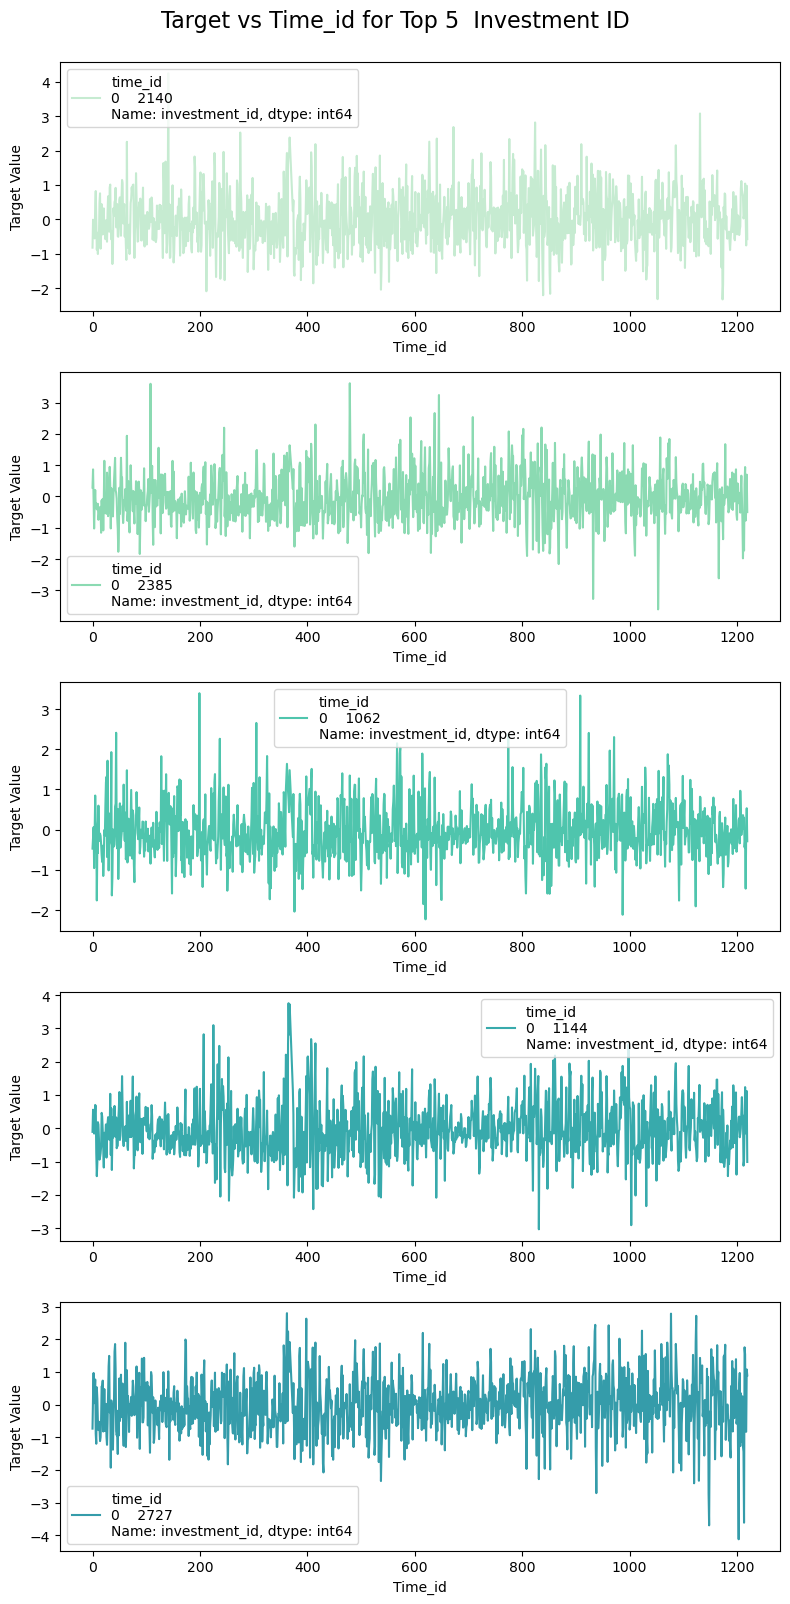

In [24]:
# Plot the target value for top investment id
f= plt.figure(figsize=(8,16))  

def gplot(no, data, color):
    ax=f.add_subplot(no)
    plt.plot(data["target"], label=data["investment_id"].head(1), color=color)
    plt.legend()
    plt.xlabel("Time_id")
    plt.ylabel("Target Value")
    return plt

gplot(no=511, data=id1, color="#c6ebd1")
gplot(no=512, data=id2, color="#8bdab2")
gplot(no=513, data=id3, color="#4fc5ad")
gplot(no=514, data=id4, color="#38aaac")
gplot(no=515, data=id5, color="#359caa")
plt.suptitle('Target vs Time_id for Top 5  Investment ID', y=1, size=16) 
plt.tight_layout()
plt.show()

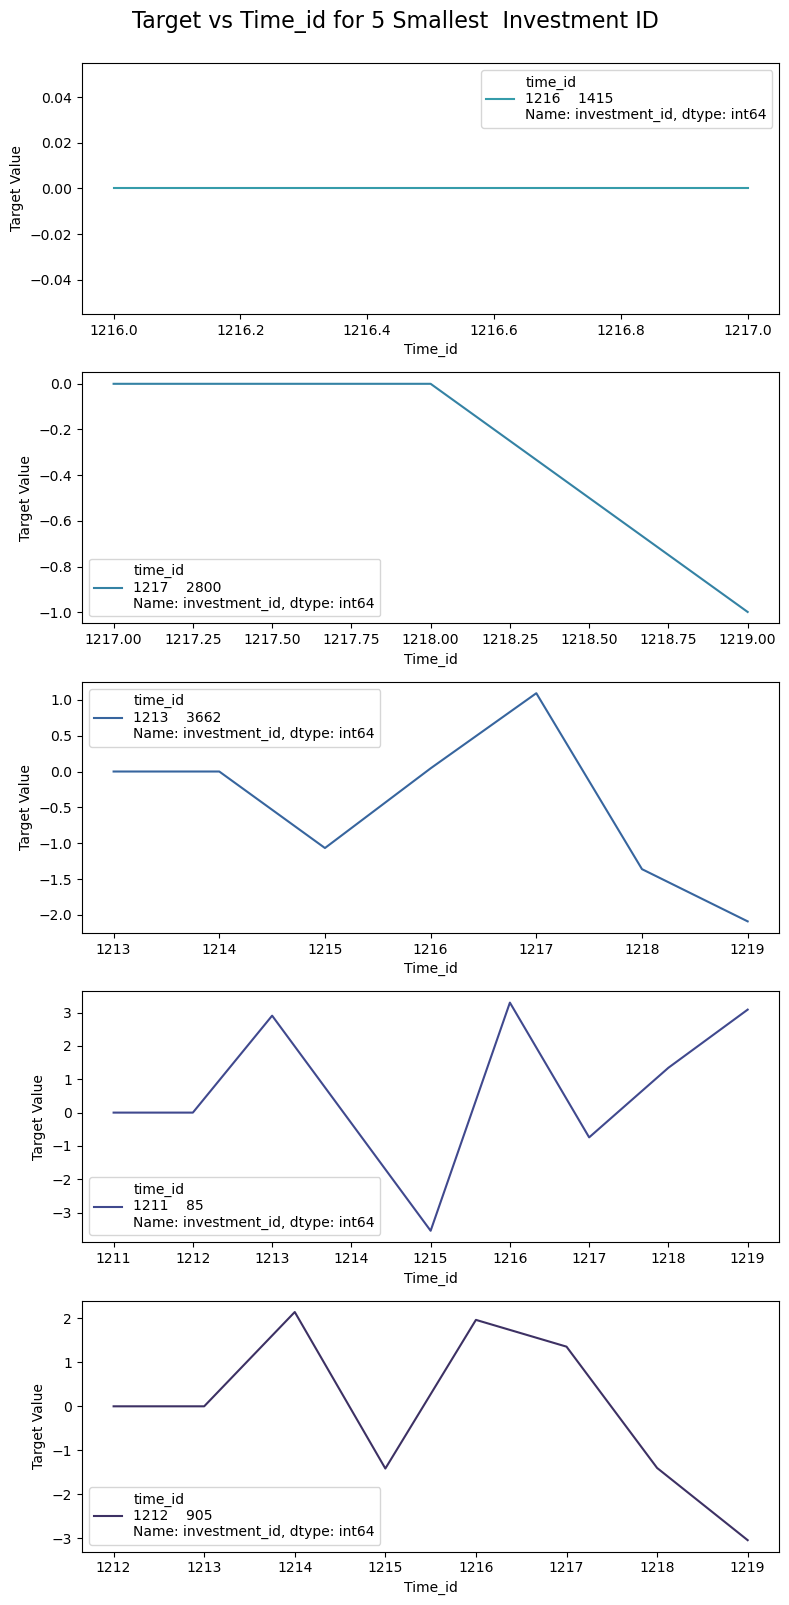

In [25]:
# Plot the target value for smallest investment id
f= plt.figure(figsize=(8,16))  

def gplot(no, data, color):
    ax=f.add_subplot(no)
    plt.plot(data["target"], label=data["investment_id"].head(1), color=color)
    plt.legend()
    plt.xlabel("Time_id")
    plt.ylabel("Target Value")
    return plt

gplot(no=511, data=id6, color="#359caa")
gplot(no=512, data=id7, color="#3482a4")
gplot(no=513, data=id8, color="#37659e")
gplot(no=514, data=id9, color="#40498e")
gplot(no=515, data=id10, color="#3d3164")
plt.suptitle('Target vs Time_id for 5 Smallest  Investment ID', y=1, size=16) 
plt.tight_layout()
plt.show()

迷你相关性图

我们将使用0.01%的数据来生成相关性图

In [26]:
data_types_dict = {
    'time_id': 'int32',
    'investment_id': 'int16',
    "target": 'float16',
}

features = [f'f_{i}' for i in range(300)]

for f in features:
    data_types_dict[f] = 'float16'
    
target = 'target'

D:\anaconda\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


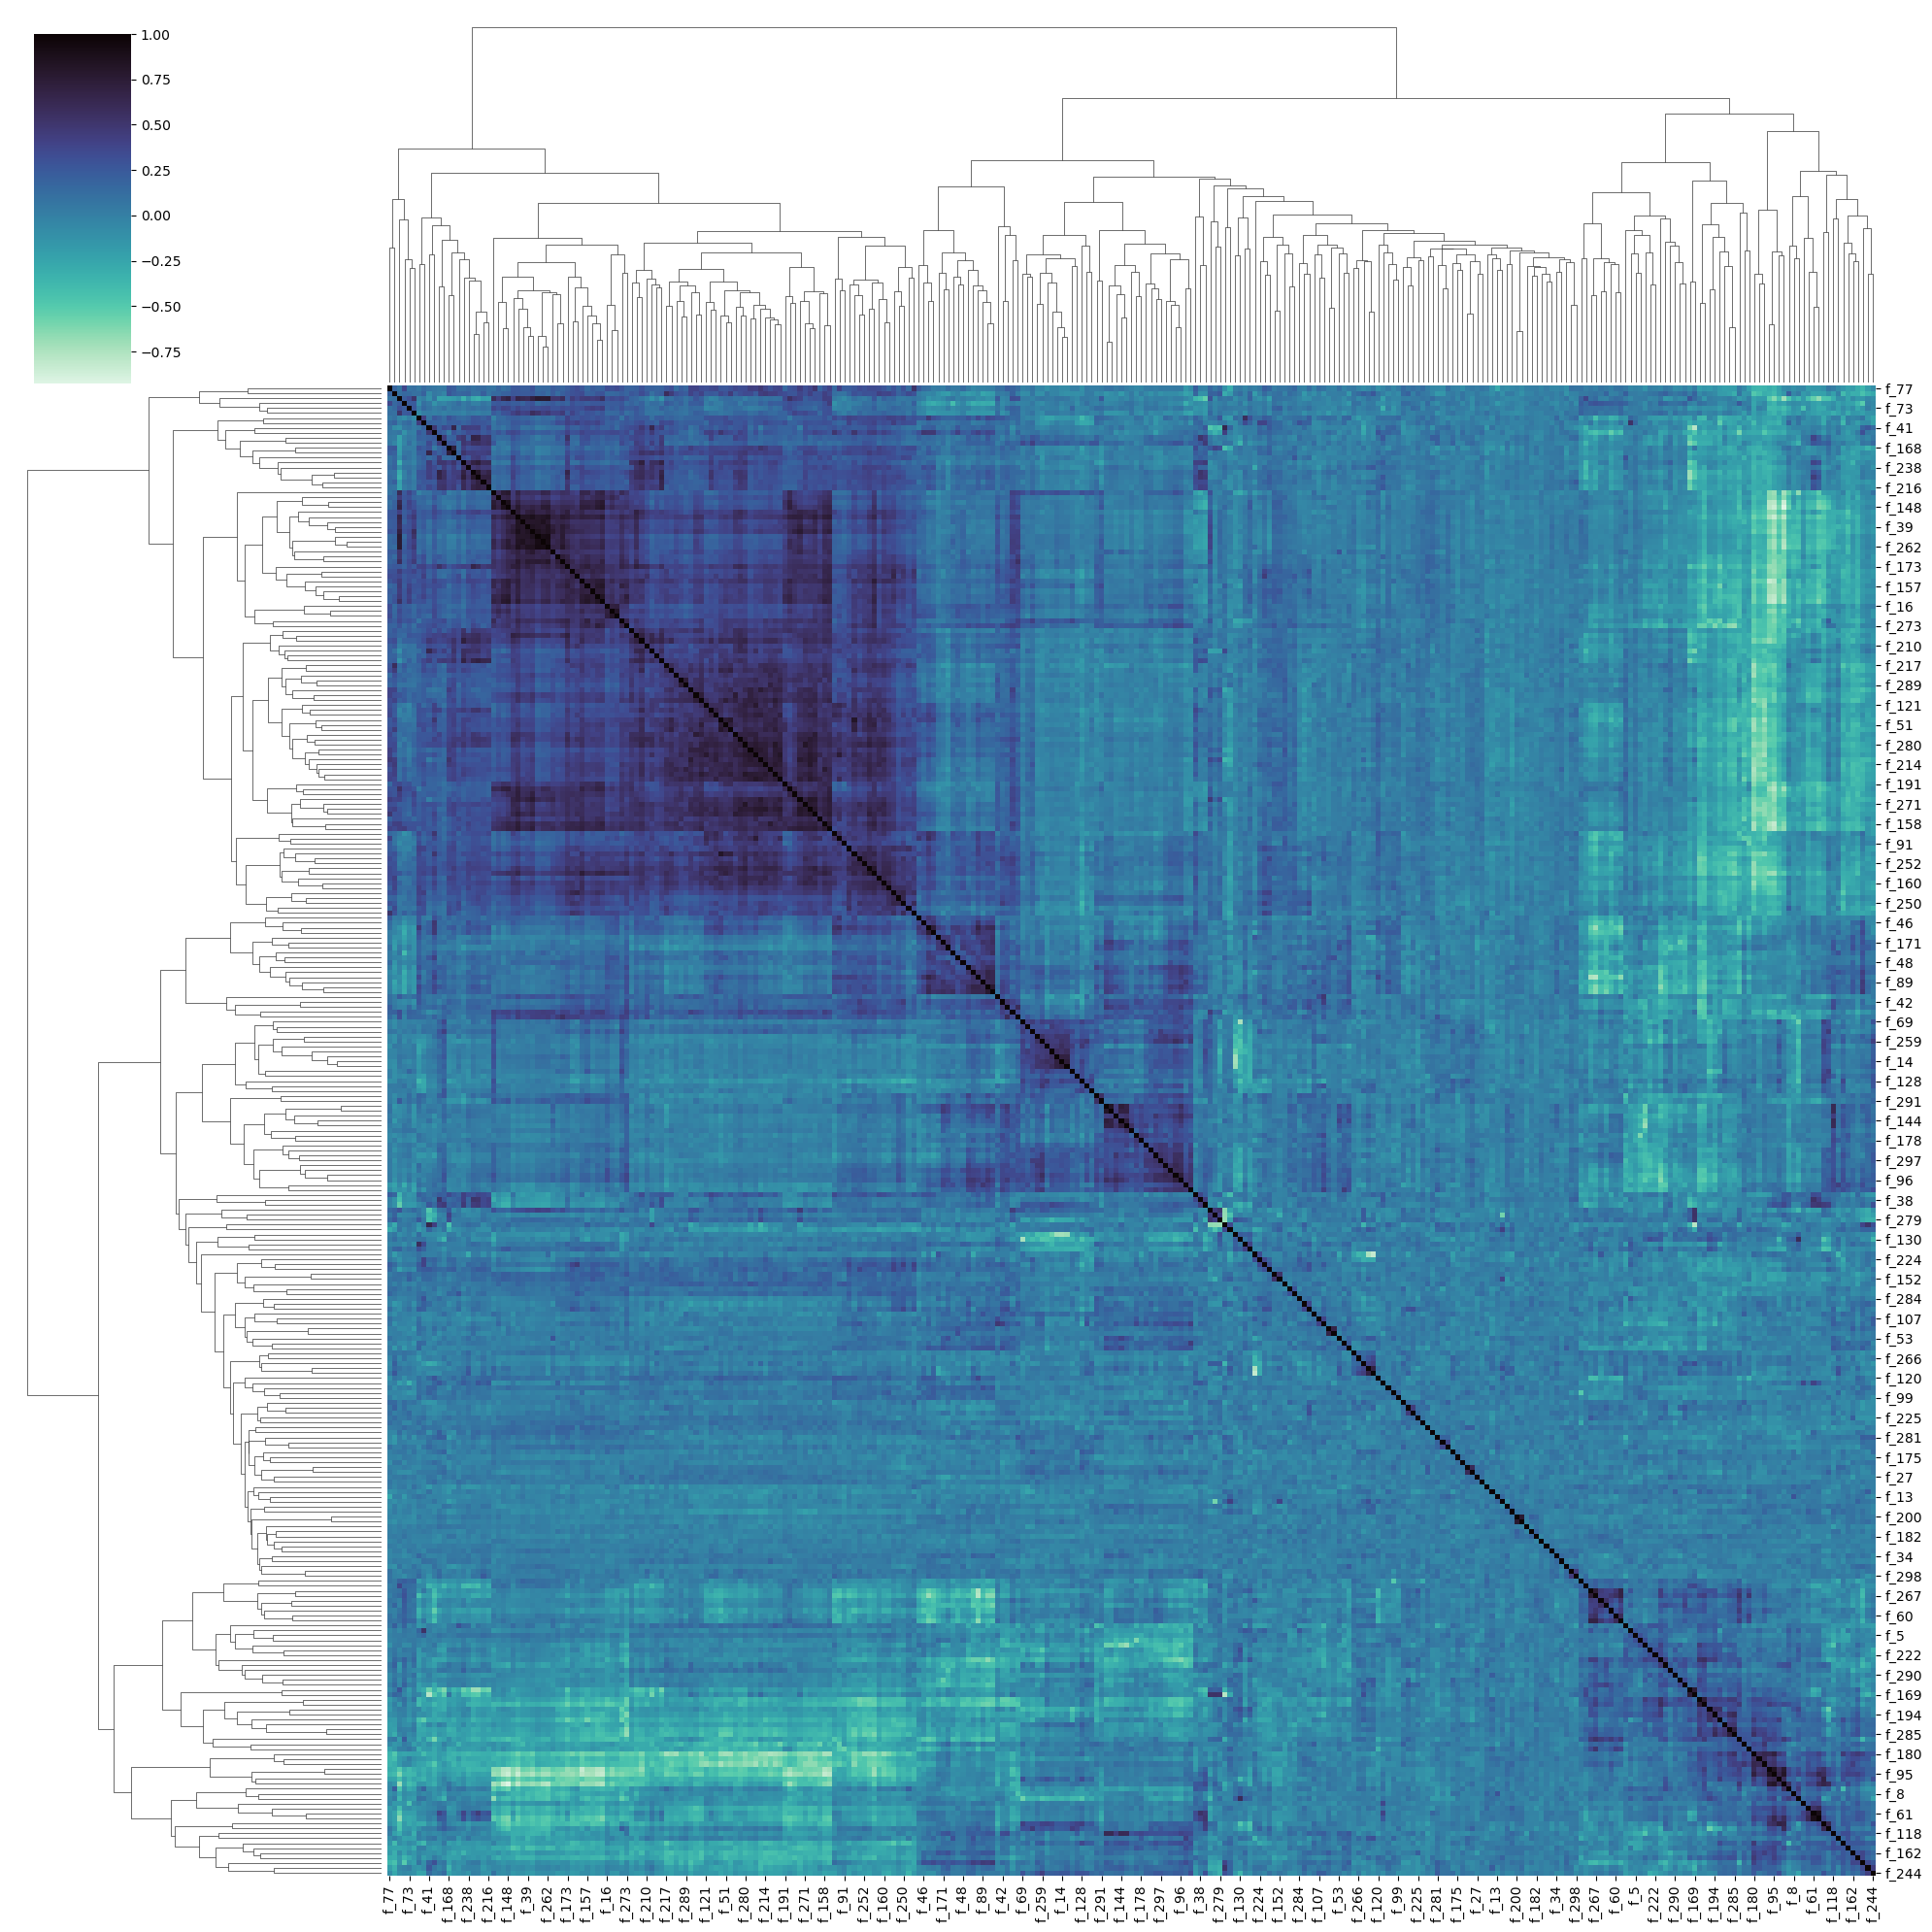

In [27]:
sample_corr=train.sample(frac=0.0001, random_state=18)
correlation = sample_corr[[target] + features].corr()
sns.clustermap(correlation, figsize=(20, 20), cmap="mako_r")

3.✨ 迷你通用功能选择

由于计算能力不足，我们的计算机一直在重新启动内核。
因此，我们决定使用1%的泛在数据进行小型分析。

In [28]:
#seed
s_train=train.sample(frac=0.01, random_state=8)

相关性特征重要性

这个项目的一个挑战是，这些功能是编码的，即使我们弄清楚了哪些功能更重要，我们也很难解释它们。
我在金融行业中搜索了一些被认为至关重要的示例特征。

Sigma ML模型的两个主要特征>1。相对就业规模：这可以被视为股票对工资通胀敏感性>2的指标。工业：有些部门（和行业）对通货膨胀的敏感度高于其他部门。股息支付率：具有短期现金流的价值型股票受通胀上升>4的影响较小。每股收益增长>5。每位员工的收入>6。经营现金流稳定性>7。资产回报率>8。利润率：也许利润率高的公司在高通胀时期有更好的生存机会

In [29]:
obs_by_asset = s_train.groupby(['investment_id'])['target'].count().to_dict()
target = s_train.investment_id.copy().replace(obs_by_asset).astype(np.int16)
features = s_train.columns[4:]

del(obs_by_asset)

In [30]:
corrs = list()
for col in features:
    corr = np.corrcoef(target, s_train[col])[0][1]
    corrs.append(corr)
    
del(target)

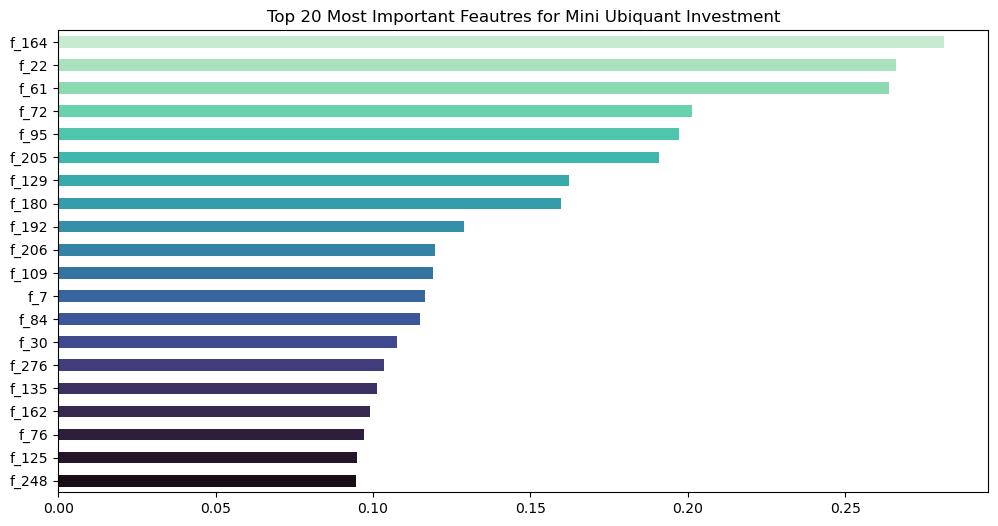

In [31]:
feat_importances = pd.Series(corrs, index=features)
feat_importances.nlargest(20).plot(kind='barh', figsize=(12, 6),
                                   color=("#c6ebd1","#abe2be","#8bdab2","#68d1ad","#4fc5ad",
                                          "#40b7ad","#38aaac","#359caa","#348fa7","#3482a4",
                                           "#3573a1","#37659e","#3b5799","#40498e","#413d7b",
                                         "#3d3164","#37284f","#2e1e3b","#241628","#180d16")).invert_yaxis()
plt.title("Top 20 Most Important Feautres for Mini Ubiquant Investment")
plt.show()

Lgbm功能重要性

In [32]:
data_types_dict = {
    'time_id': 'int32',
    'investment_id': 'int16',
    "target": 'float16',
}

features = [f'f_{i}' for i in range(300)]

for f in features:
    data_types_dict[f] = 'float16'
    
target = 'target'

In [41]:
seed = 8
folds = 5
models = []

skf = StratifiedKFold(folds, shuffle = True, random_state = seed)

for train_index, test_index in skf.split(s_train, s_train['investment_id']):
    train1 = s_train.iloc[train_index]
    valid1 = s_train.iloc[test_index]
    
    lgbm = LGBMRegressor(
        num_leaves=2 ** np.random.randint(3, 8),
        learning_rate = 10 ** (-np.random.uniform(0.1,2)),
        n_estimators = 1000,
        min_child_samples = 1000, 
        subsample=np.random.uniform(0.5,1.0), 
        subsample_freq=1,
        n_jobs= -1
    )

    lgbm.fit(train1[features], train1[target], eval_set = (valid1[features], valid1[target]), early_stopping_rounds = 10)
    models.append(lgbm)

D:\anaconda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
D:\anaconda\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.83505
[2]	valid_0's l2: 0.834031
[3]	valid_0's l2: 0.833283
[4]	valid_0's l2: 0.832613
[5]	valid_0's l2: 0.831804
[6]	valid_0's l2: 0.831277
[7]	valid_0's l2: 0.831061
[8]	valid_0's l2: 0.830414
[9]	valid_0's l2: 0.829684
[10]	valid_0's l2: 0.829053
[11]	valid_0's l2: 0.828103
[12]	valid_0's l2: 0.827979
[13]	valid_0's l2: 0.827349
[14]	valid_0's l2: 0.826532
[15]	valid_0's l2: 0.825988
[16]	valid_0's l2: 0.825784
[17]	valid_0's l2: 0.825549
[18]	valid_0's l2: 0.825184
[19]	valid_0's l2: 0.824998
[20]	valid_0's l2: 0.824862
[21]	valid_0's l2: 0.824292
[22]	valid_0's l2: 0.824088
[23]	valid_0's l2: 0.823861
[24]	valid_0's l2: 0.82376
[25]	valid_0's l2: 0.823533
[26]	valid_0's l2: 0.823126
[27]	valid_0's l2: 0.823239
[28]	valid_0's l2: 0.823184
[29]	valid_0's l2: 0.822379
[30]	valid_0's l2: 0.822407
[31]	valid_0's l2: 0.822121
[32]	valid_0's l2: 0.822101
[33]	valid_0's l2: 0.822341
[34]	valid_0's l2: 0.822157
[35]	valid_0's l2: 0.822185
[36]	valid_0's l2: 0.821981
[37

D:\anaconda\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.862284
[2]	valid_0's l2: 0.861788
[3]	valid_0's l2: 0.861211
[4]	valid_0's l2: 0.860831
[5]	valid_0's l2: 0.860378
[6]	valid_0's l2: 0.859956
[7]	valid_0's l2: 0.859674
[8]	valid_0's l2: 0.859157
[9]	valid_0's l2: 0.858782
[10]	valid_0's l2: 0.85833
[11]	valid_0's l2: 0.857974
[12]	valid_0's l2: 0.857566
[13]	valid_0's l2: 0.857277
[14]	valid_0's l2: 0.857182
[15]	valid_0's l2: 0.856975
[16]	valid_0's l2: 0.856607
[17]	valid_0's l2: 0.856374
[18]	valid_0's l2: 0.856274
[19]	valid_0's l2: 0.856064
[20]	valid_0's l2: 0.855904
[21]	valid_0's l2: 0.855653
[22]	valid_0's l2: 0.855557
[23]	valid_0's l2: 0.855326
[24]	valid_0's l2: 0.855038
[25]	valid_0's l2: 0.854768
[26]	valid_0's l2: 0.854542
[27]	valid_0's l2: 0.854566
[28]	valid_0's l2: 0.854454
[29]	valid_0's l2: 0.854419
[30]	valid_0's l2: 0.854233
[31]	valid_0's l2: 0.854102
[32]	valid_0's l2: 0.85388
[33]	valid_0's l2: 0.85371
[34]	valid_0's l2: 0.853533
[35]	valid_0's l2: 0.853405
[36]	valid_0's l2: 0.853332
[37]

D:\anaconda\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.830574
[2]	valid_0's l2: 0.830389
[3]	valid_0's l2: 0.830246
[4]	valid_0's l2: 0.830007
[5]	valid_0's l2: 0.829808
[6]	valid_0's l2: 0.829643
[7]	valid_0's l2: 0.829493
[8]	valid_0's l2: 0.829296
[9]	valid_0's l2: 0.829122
[10]	valid_0's l2: 0.828952
[11]	valid_0's l2: 0.828776
[12]	valid_0's l2: 0.8286
[13]	valid_0's l2: 0.828478
[14]	valid_0's l2: 0.828337
[15]	valid_0's l2: 0.82823
[16]	valid_0's l2: 0.828078
[17]	valid_0's l2: 0.827949
[18]	valid_0's l2: 0.827837
[19]	valid_0's l2: 0.827749
[20]	valid_0's l2: 0.827665
[21]	valid_0's l2: 0.827512
[22]	valid_0's l2: 0.827436
[23]	valid_0's l2: 0.82727
[24]	valid_0's l2: 0.827212
[25]	valid_0's l2: 0.827089
[26]	valid_0's l2: 0.827019
[27]	valid_0's l2: 0.826979
[28]	valid_0's l2: 0.826845
[29]	valid_0's l2: 0.826661
[30]	valid_0's l2: 0.826595
[31]	valid_0's l2: 0.826487
[32]	valid_0's l2: 0.826429
[33]	valid_0's l2: 0.826357
[34]	valid_0's l2: 0.826269
[35]	valid_0's l2: 0.826234
[36]	valid_0's l2: 0.826155
[37]	

D:\anaconda\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.902908
[2]	valid_0's l2: 0.901221
[3]	valid_0's l2: 0.900738
[4]	valid_0's l2: 0.900268
[5]	valid_0's l2: 0.90005
[6]	valid_0's l2: 0.899934
[7]	valid_0's l2: 0.899874
[8]	valid_0's l2: 0.900502
[9]	valid_0's l2: 0.901045
[10]	valid_0's l2: 0.902564
[11]	valid_0's l2: 0.903036
[12]	valid_0's l2: 0.903237
[13]	valid_0's l2: 0.904391
[14]	valid_0's l2: 0.904508
[15]	valid_0's l2: 0.903943
[16]	valid_0's l2: 0.903017
[17]	valid_0's l2: 0.903126


D:\anaconda\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.883671
[2]	valid_0's l2: 0.882532
[3]	valid_0's l2: 0.881905
[4]	valid_0's l2: 0.880857
[5]	valid_0's l2: 0.880485
[6]	valid_0's l2: 0.879535
[7]	valid_0's l2: 0.879091
[8]	valid_0's l2: 0.878219
[9]	valid_0's l2: 0.877879
[10]	valid_0's l2: 0.877863
[11]	valid_0's l2: 0.876998
[12]	valid_0's l2: 0.877101
[13]	valid_0's l2: 0.876646
[14]	valid_0's l2: 0.87602
[15]	valid_0's l2: 0.875554
[16]	valid_0's l2: 0.875304
[17]	valid_0's l2: 0.875357
[18]	valid_0's l2: 0.875334
[19]	valid_0's l2: 0.875444
[20]	valid_0's l2: 0.875464
[21]	valid_0's l2: 0.875477
[22]	valid_0's l2: 0.875629
[23]	valid_0's l2: 0.875407
[24]	valid_0's l2: 0.875364
[25]	valid_0's l2: 0.874853
[26]	valid_0's l2: 0.874692
[27]	valid_0's l2: 0.874925
[28]	valid_0's l2: 0.874755
[29]	valid_0's l2: 0.874874
[30]	valid_0's l2: 0.874959
[31]	valid_0's l2: 0.875401
[32]	valid_0's l2: 0.87572
[33]	valid_0's l2: 0.875591
[34]	valid_0's l2: 0.875362
[35]	valid_0's l2: 0.875562
[36]	valid_0's l2: 0.875332


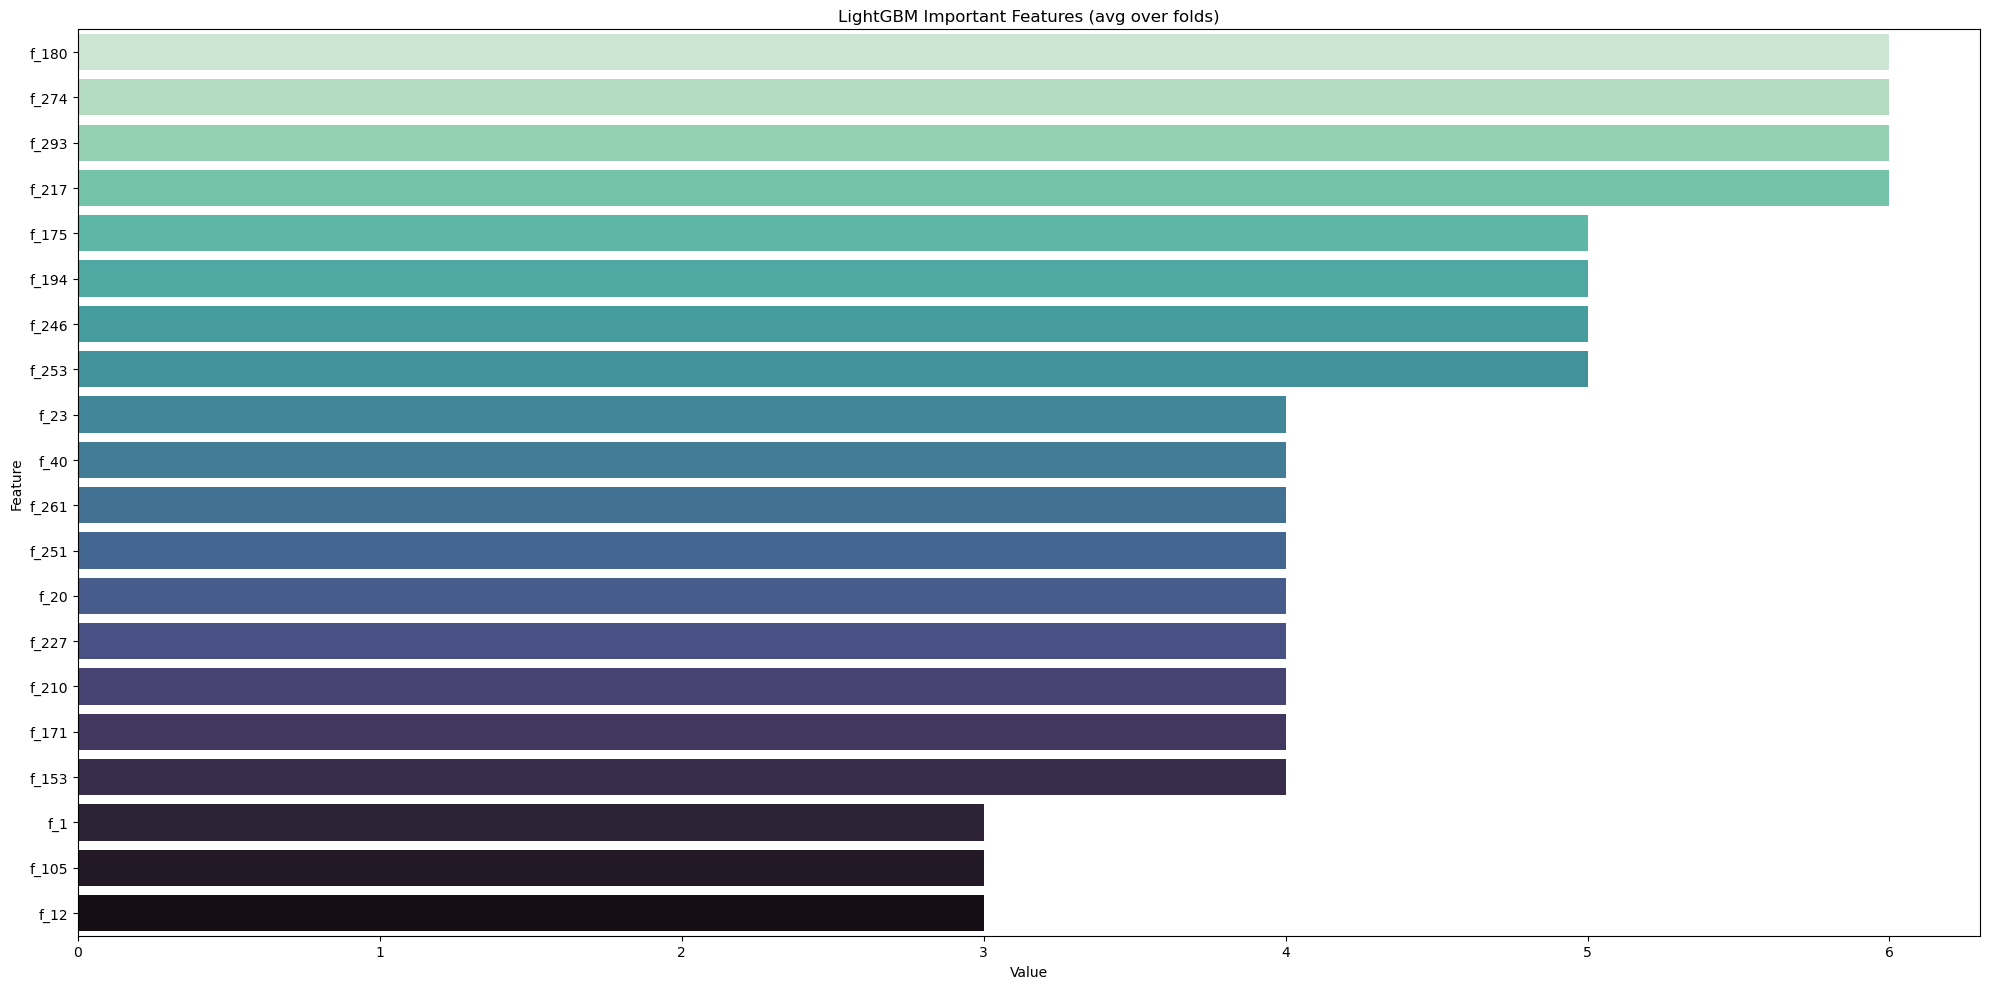

In [42]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,s_train.columns)), columns=['Value','Feature']).nlargest(20,"Value")

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False),  palette='mako_r')
plt.title('LightGBM Important Features (avg over folds)')
plt.tight_layout()
plt.show()

#4.🌅 迷你通用功能EDA¶

我们将介绍LGBM和常规模型的功能EDA选择。

In [37]:
df = pd.DataFrame(s_train, columns= ["row_id","time_id","investment_id","target" ,'f_22','f_30',"f_61","f_72","f_90","f_95","f_97","f_113","f_164","f_194"])
df.head()

,row_id,time_id,investment_id,target,f_22,f_30,f_61,f_72,f_90,f_95,f_97,f_113,f_164,f_194
2566567,1043_1667,1043,1667,0.257255,0.756215,0.361034,-0.337621,0.801462,-0.582648,-0.019839,-0.921737,0.118474,-0.204445,1.527509
2884377,1143_79,1143,79,-0.265160,0.794739,0.444490,0.933020,1.515557,-0.400919,1.688982,-0.997126,-1.047375,1.460346,1.479775
1209567,563_707,563,707,-0.768063,0.439959,0.623252,2.193136,0.650465,-0.404190,0.904188,-0.917653,-0.162424,1.563955,-0.830400
1470297,666_3388,666,3388,-0.338682,0.071868,0.378192,0.833014,1.743665,-0.704371,2.327423,-0.882430,-0.573053,1.518637,-0.546037
3053938,1194_1620,1194,1620,-1.636054,-1.149892,-1.788076,-1.088801,-0.930209,1.872669,-1.157512,0.850817,0.947556,-1.873494,-0.880712


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23524\4086186822.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[f'f_{sample}'], ax=ax[math.floor(i/3),i%3],color='#38aaac').set_title(f'f_{sample} Distribution')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23524\4086186822.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de

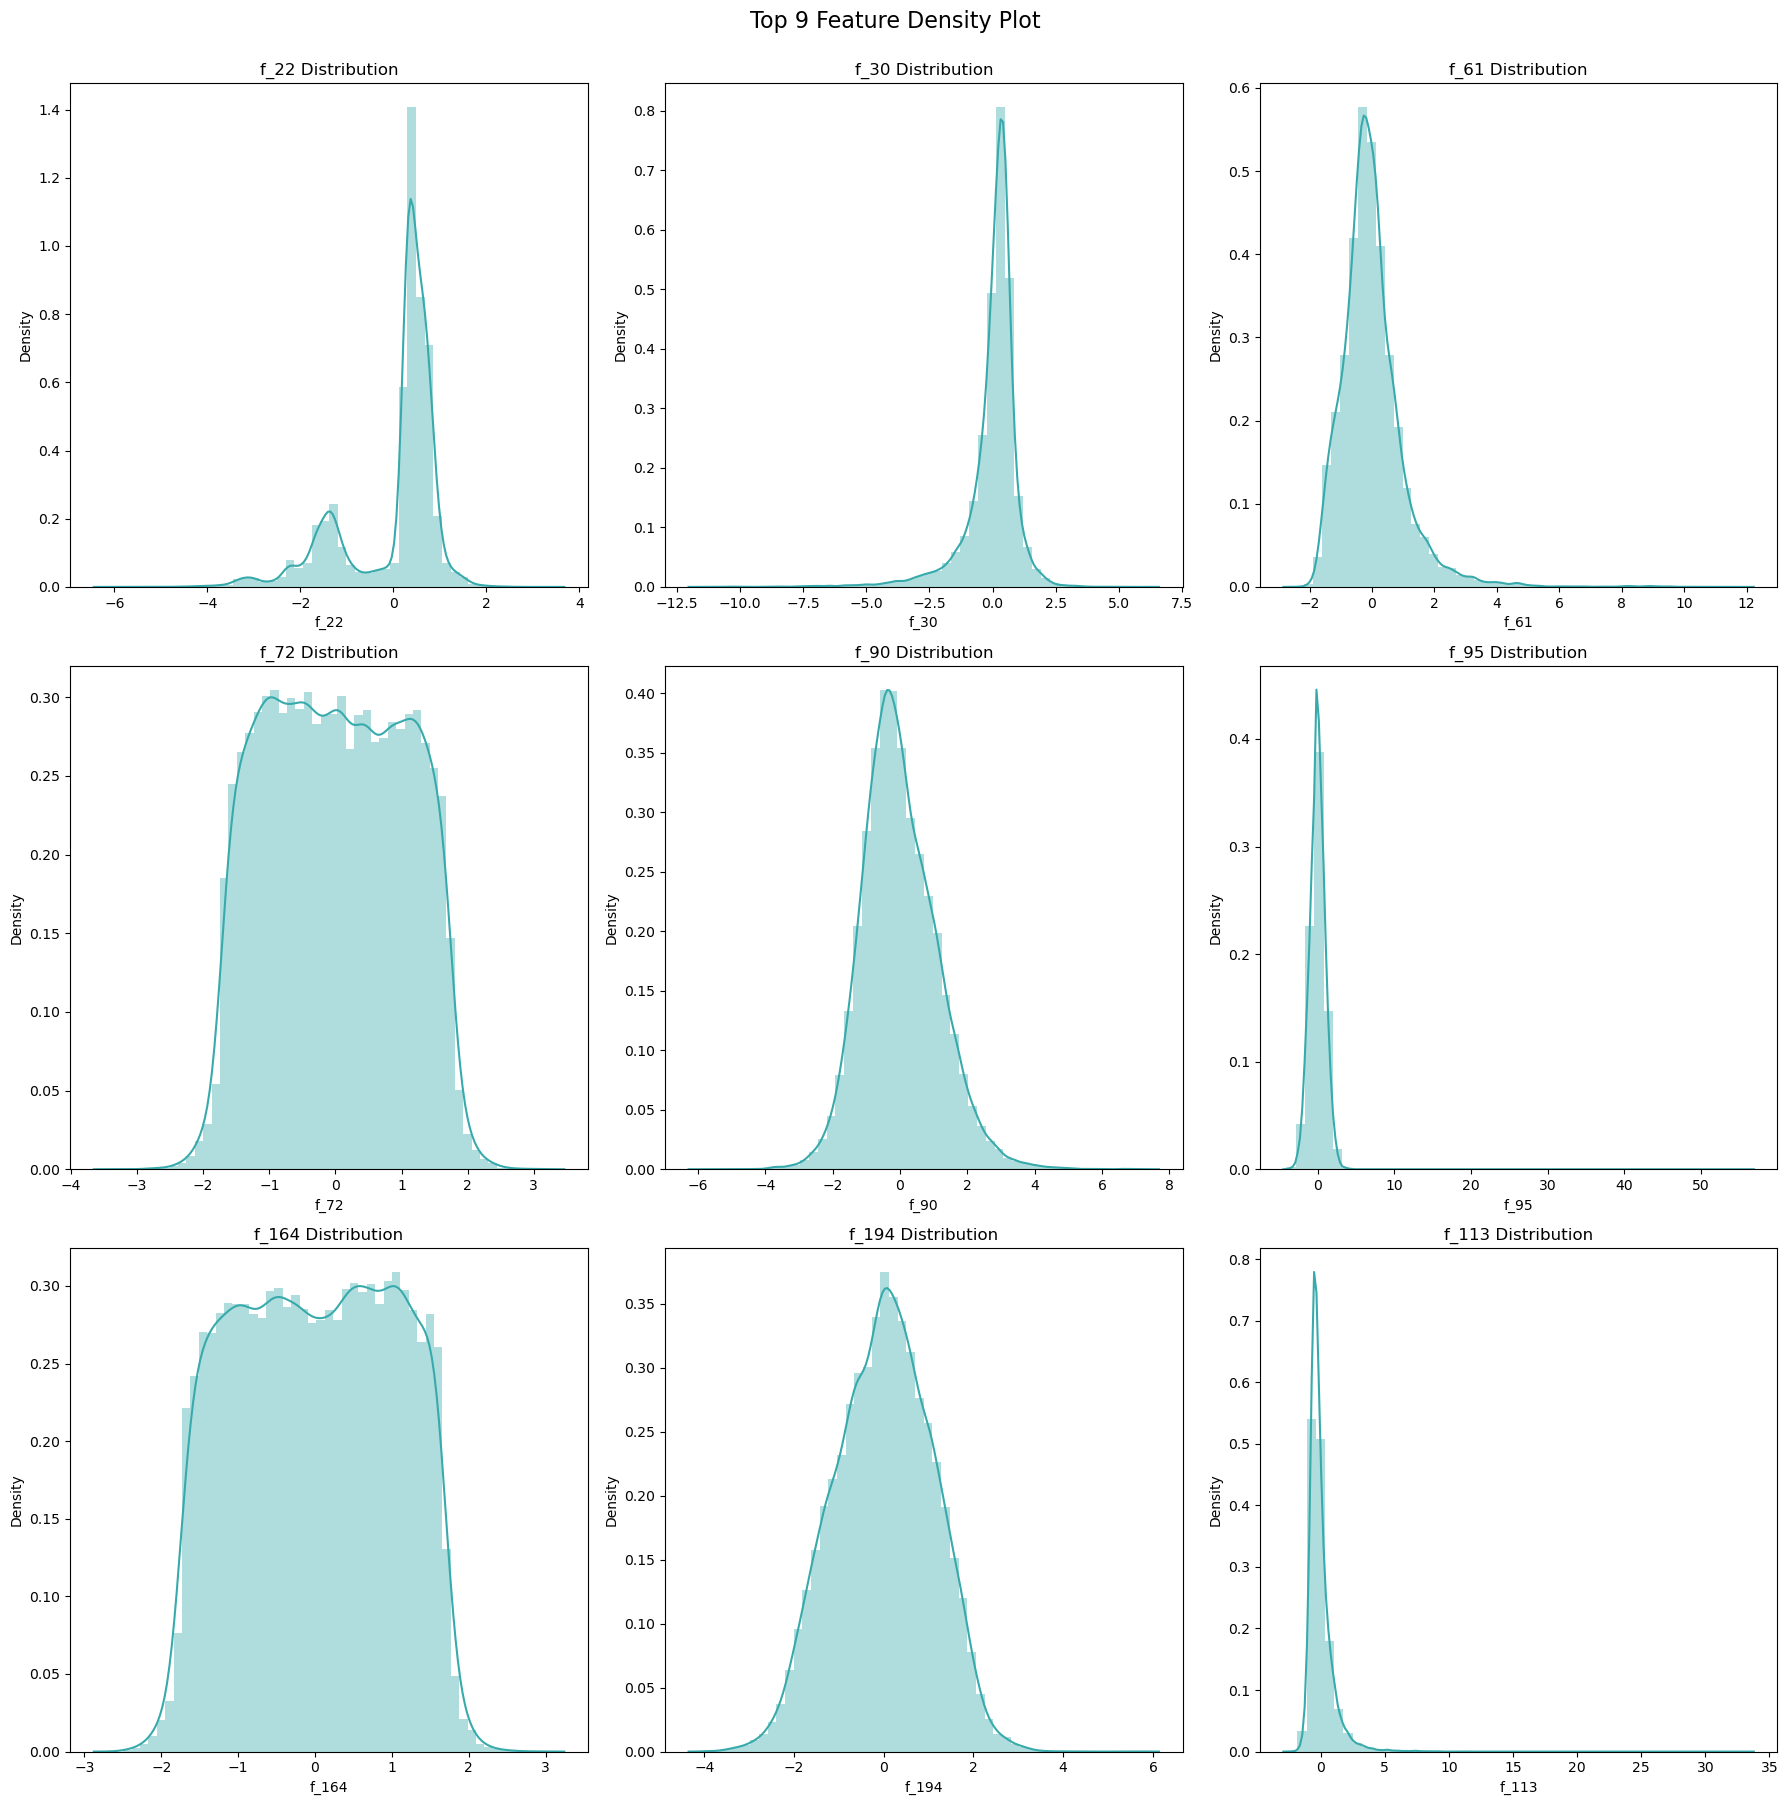

In [38]:
sample_features =[22,30,61,72,90,95,164,194,113]
fig, ax = plt.subplots(3,3, figsize=(18, 18))
for i, sample in enumerate(sample_features):
    sns.distplot(df[f'f_{sample}'], ax=ax[math.floor(i/3),i%3],color='#38aaac').set_title(f'f_{sample} Distribution')
fig.suptitle('Top 9 Feature Density Plot', y=1, size=16) 
fig.tight_layout()
fig.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23524\883539971.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


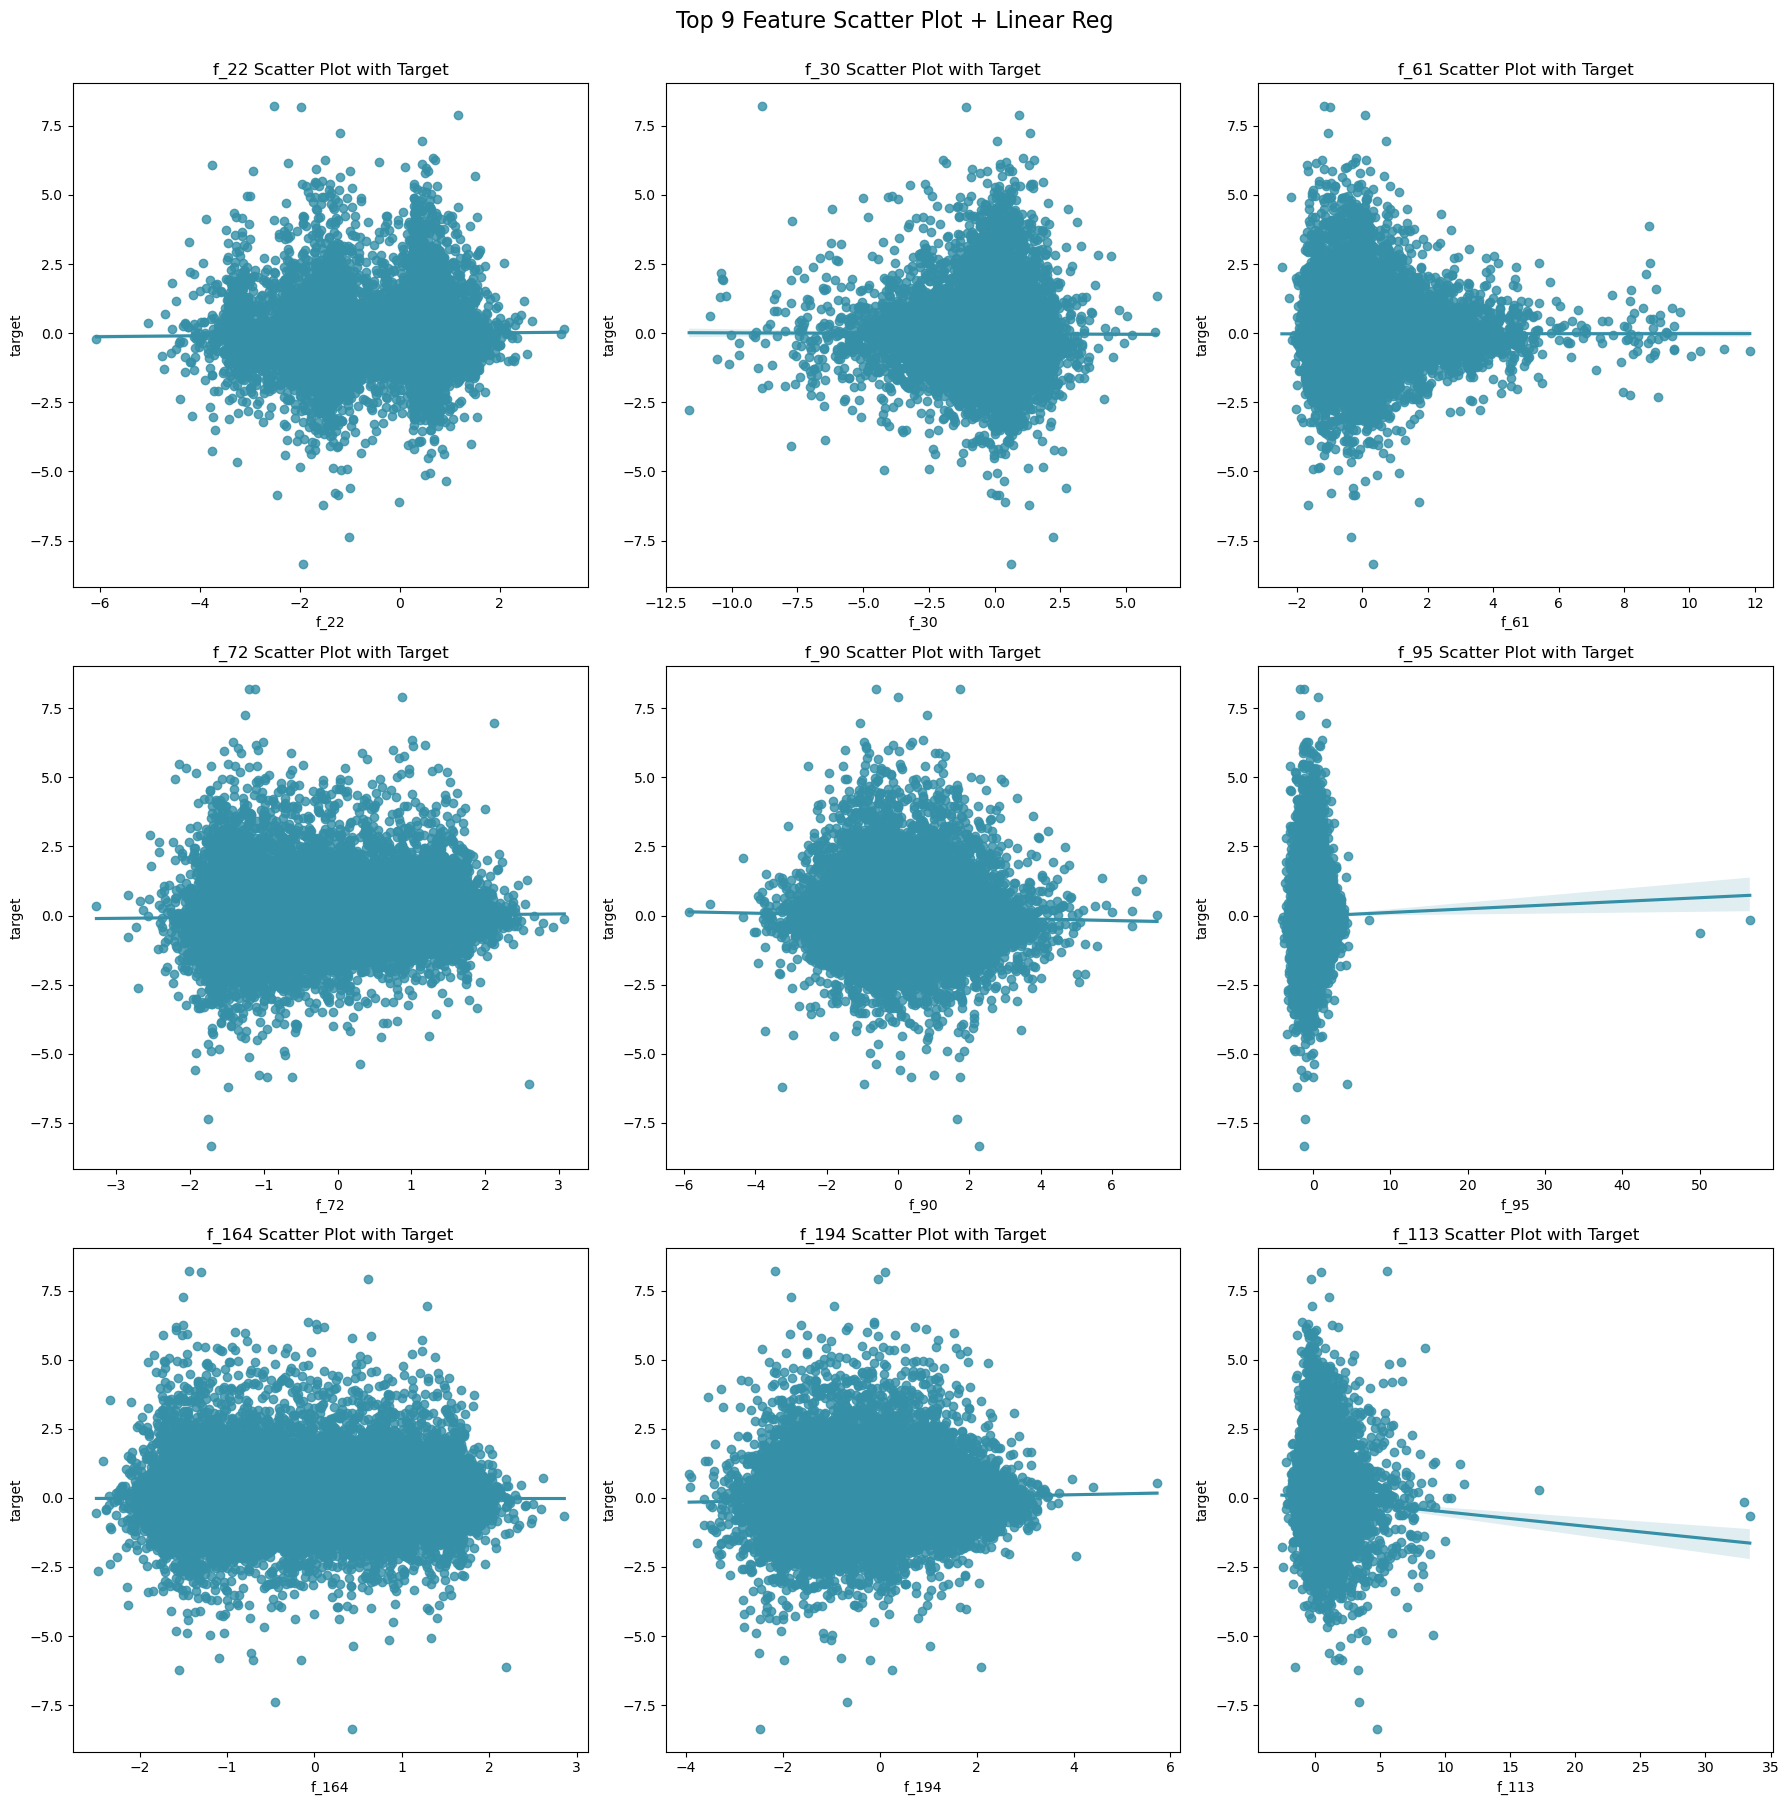

In [39]:
fig, ax = plt.subplots(3,3, figsize=(18, 18))
for i, sample in enumerate(sample_features):
    sns.regplot(data=df, x=df[f'f_{sample}'], y="target", ax=ax[math.floor(i/3),i%3],color='#348fa7').set_title(f'f_{sample} Scatter Plot with Target')
fig.suptitle('Top 9 Feature Scatter Plot + Linear Reg', y=1, size=16) 
fig.tight_layout()
fig.show()